In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import collections
from matplotlib.pyplot import show
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 1
%aimport study_utils
%aimport lausanne_2016_utils

In [2]:
PATH_TO_DATA = '../../Scraping/DataSport/Data/Lausanne_Marathon_2016.pickle'

# Data wrangling

In this first part, we retrieve data of Lausanne Marathon 2016 and we manipulate the different columns in order to exploit them during the analysis part.

First, we use the pickle format to allow faster import of the data, and correct formatting of some columns as date columns.

Note: Same data are also available in CSV (readable format).

In [3]:
lausanne_marathon_2016 = pd.read_pickle(PATH_TO_DATA)
lausanne_marathon_2016.head()

,birthday,name,rank,time,number,team,acode,category
0,1976-01-01 00:00:00,Waardenburg George,285.0,1900-01-01 00:50:26.600000,11404,NaN,CPQP6ZGUB,10-H40
1,1997-01-01 00:00:00,Waeber Jean,186.0,1900-01-01 00:53:10.800000,13468,NaN,X4HC5EYRT,10-JunG
2,1963-01-01 00:00:00,Waeber Marie-Jo,17.0,1900-01-01 00:48:47.500000,11449,NaN,HAP8H6A7Q,10-D50
3,1979-01-01 00:00:00,Waeber Pascal,778.0,1900-01-01 02:03:58.500000,6523,NaN,ZT9BYS5M3,21-H30
4,1970-01-01 00:00:00,Waeber Yvette,11.0,1900-01-01 01:34:50.700000,6441,NaN,2T9WCSAM7,21-D40


Some participants are part of categories which must be excluded as these categories are not representative or can be misleading for the analysis part.

In [4]:
lausanne_marathon_2016_cleaned = lausanne_marathon_2016[lausanne_marathon_2016.apply(study_utils.filter_participants, axis=1)].copy()

Here, we know the categories of the runners and these categories contains sex information about the participants (for a given type of running, we have two subcategories for male and female runners, as usual in such sports). Thus, we use this information to create a new column giving the sex of each participants.

In [5]:
lausanne_marathon_2016_cleaned['sex'] = lausanne_marathon_2016_cleaned.apply(study_utils.get_sex_of_runner, axis=1)

In [6]:
lausanne_marathon_2016_cleaned['sex'].value_counts(dropna=False)

male      6801
female    4447
Name: sex, dtype: int64

In [7]:
len(lausanne_marathon_2016_cleaned)

11248

At the end of this stage, we have a total of 11248 runners on whom we can run our analysis for Lausanne Marathon 2016.

We also extract from the category the fact that a runner is either junior or adult.

In [8]:
lausanne_marathon_2016_cleaned['type'] = lausanne_marathon_2016_cleaned.apply(study_utils.get_type_of_runner, axis=1)

We also transform the *number* and *rank* columns, as they contain integer.

In [9]:
lausanne_marathon_2016_cleaned['number'] = lausanne_marathon_2016_cleaned['number'].apply(lambda x : int(float(x)))

In [10]:
lausanne_marathon_2016_cleaned['rank'] = lausanne_marathon_2016_cleaned['rank'].apply(lambda x : int(float(x)))

In [11]:
lausanne_marathon_2016_cleaned.head()

,birthday,name,rank,time,number,team,acode,category,sex,type
0,1976-01-01 00:00:00,Waardenburg George,285,1900-01-01 00:50:26.600000,11404,NaN,CPQP6ZGUB,10-H40,male,adult
1,1997-01-01 00:00:00,Waeber Jean,186,1900-01-01 00:53:10.800000,13468,NaN,X4HC5EYRT,10-JunG,male,junior
2,1963-01-01 00:00:00,Waeber Marie-Jo,17,1900-01-01 00:48:47.500000,11449,NaN,HAP8H6A7Q,10-D50,female,adult
3,1979-01-01 00:00:00,Waeber Pascal,778,1900-01-01 02:03:58.500000,6523,NaN,ZT9BYS5M3,21-H30,male,adult
4,1970-01-01 00:00:00,Waeber Yvette,11,1900-01-01 01:34:50.700000,6441,NaN,2T9WCSAM7,21-D40,female,adult


We also compute the age of runner based on the birthyear, to easily manipulate such information later.

In [12]:
lausanne_marathon_2016_cleaned['age'] = lausanne_marathon_2016_cleaned.apply(study_utils.compute_age_of_runner, axis=1)
lausanne_marathon_2016_cleaned['age'] = lausanne_marathon_2016_cleaned['age'].apply(lambda x : int(float(x)))

In [13]:
lausanne_marathon_2016_cleaned['age category'] = pd.cut(lausanne_marathon_2016_cleaned['age'], [10, 26, 31, 36, 41, 46, 51, 56, 61, 66, 100], labels=['10-25 years', '26-30 years', '31-35 years', '36-40 years', '41-45 years', '46-50 years', '51-55 years', '56-60 years', '61-65 years', '65+ years'], right=False)

If the time is in readable-format, it is difficult to use it this way for analysis as comparison can be misleading. For this reason, we decide to store time in raw format (i.e. number of seconds, without any format).

In [14]:
lausanne_marathon_2016_cleaned['time'] = lausanne_marathon_2016_cleaned.apply(study_utils.format_time, axis=1)

Moreover, we store the type of running the participants did.

In [15]:
lausanne_marathon_2016_cleaned['distance (km)'] = lausanne_marathon_2016_cleaned.apply(study_utils.compute_distance_from_category, axis=1)

We also need to compute the speed by kilometer for each runners.

In [16]:
lausanne_marathon_2016_cleaned['speed (m/s)'] = lausanne_marathon_2016_cleaned['distance (km)']*1000/lausanne_marathon_2016_cleaned['time']
lausanne_marathon_2016_cleaned['profile'] = lausanne_marathon_2016_cleaned.apply(study_utils.compute_run_in_team, axis=1)

Finally, we make three distinct sets of data (10 km, semi-marathon and marathon).

In [17]:
lausanne_marathon_2016_10km = lausanne_marathon_2016_cleaned[lausanne_marathon_2016_cleaned['distance (km)'] == 10]
lausanne_marathon_2016_21km = lausanne_marathon_2016_cleaned[lausanne_marathon_2016_cleaned['distance (km)'] == 21]
lausanne_marathon_2016_42km = lausanne_marathon_2016_cleaned[lausanne_marathon_2016_cleaned['distance (km)'] == 42]

In [18]:
lausanne_marathon_2016_cleaned.to_pickle('./Data/Lausanne_Marathon_2016_cleaned.pickle')

# Complete study

## Overall study

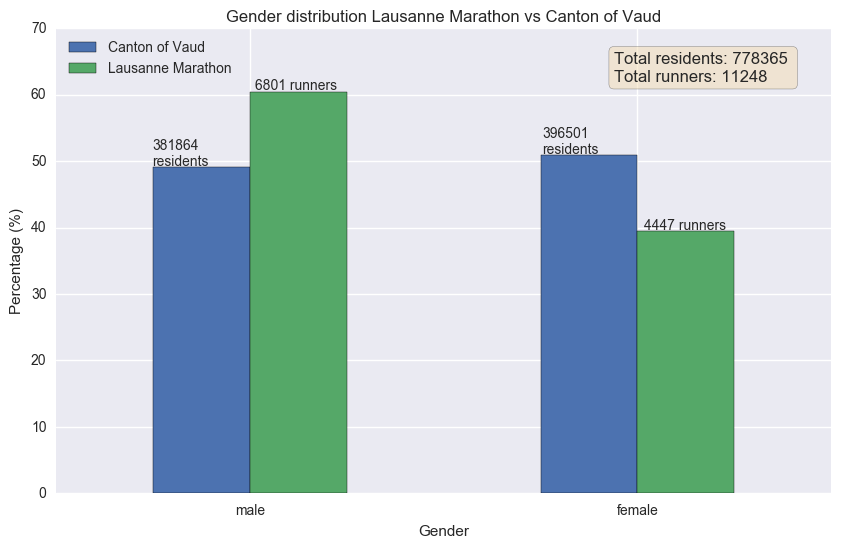

In [19]:
lausanne_2016_utils.plot_gender_distributions(lausanne_marathon_2016_cleaned)

As we can see, Lausanne Marathon race had a significantly higher percentage of male runners than female ones comparing to gender distribution of Canton of Vaud, which is equal regarding male and female.

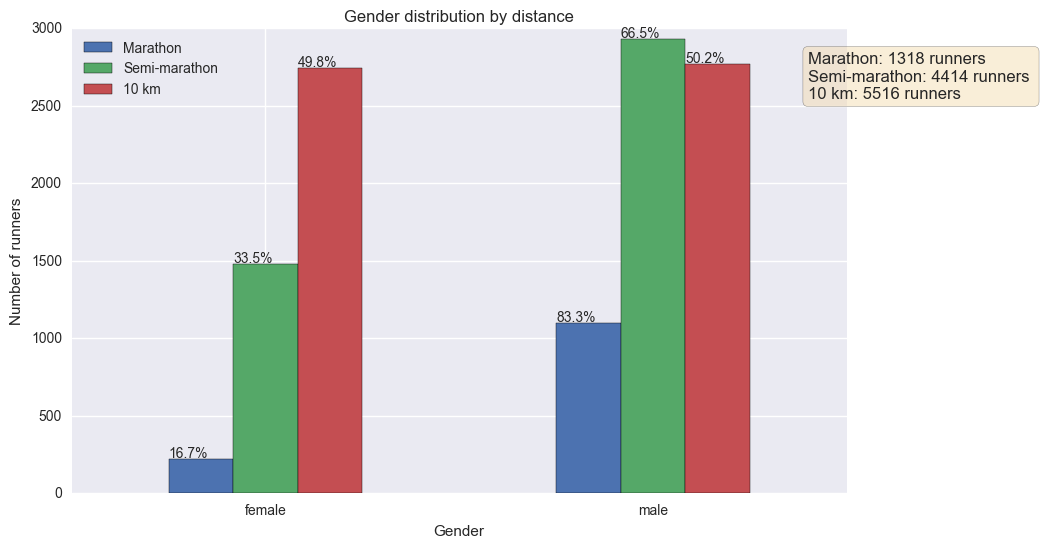

In [20]:
lausanne_2016_utils.plot_gender_distribution_according_to_running_type(lausanne_marathon_2016_10km, lausanne_marathon_2016_21km, lausanne_marathon_2016_42km)

We also see an interesting thing is that for 10 km running, distribution between male and female runners is similar, while for semi-marathon and marathon, we observe a clear difference between the repartition! According to the new direction of the Lausanne Marathon, there is a reason behind this observation.

> "Women don't even dare start the race unless they are totaly sure about mastering the distance, unlike men who sometimes finish completely exhausted.”
>
> Source: <a href="https://www.rts.ch/sport/athletisme/1258113-le-marathon-de-lausanne-change-dorientation.html">RTSSport (FR)</a>

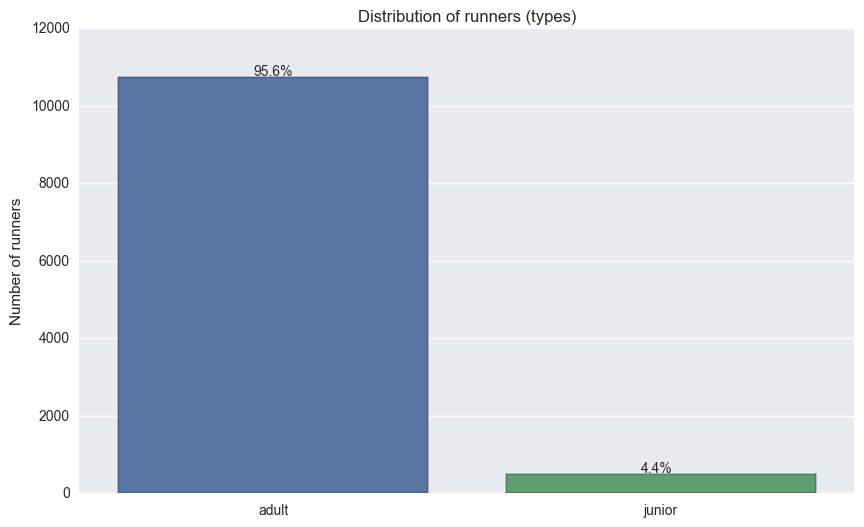

In [21]:
lausanne_2016_utils.plot_distribution_between_adults_and_juniors(lausanne_marathon_2016_cleaned)

Not surprinsingly, very minor part of runners were young runners in Lausanne Marathon of 2016. Indeed, these runnings ask a lot of effort and are very difficult for juniors runners.

## Demographic study

In this part, we plan to focus on age of runners, but also the place from which they come.

We first display the age distribution of runners in the marathon 2016 of Lausanne.

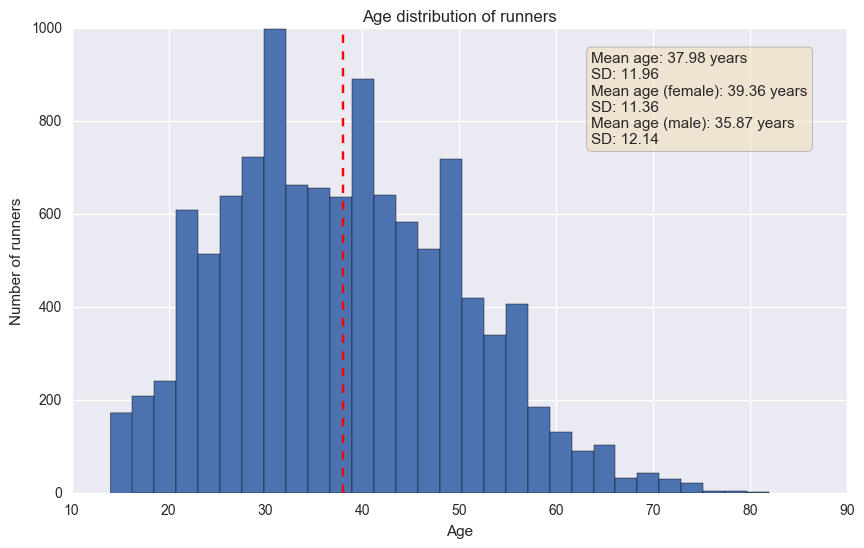

In [22]:
lausanne_2016_utils.plot_age_distribution(lausanne_marathon_2016_cleaned)

We can notice that, globally, the average age of runners is 38 years. We also observe that men are older than women!

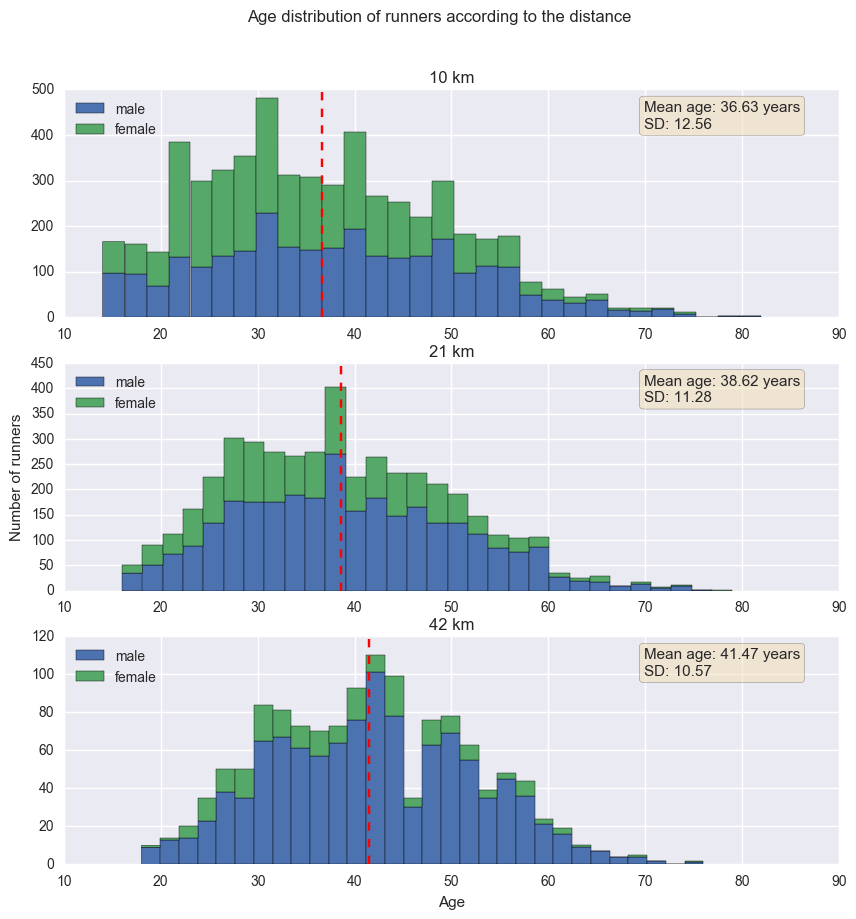

In [23]:
fig = plt.figure()
fig.tight_layout
fig.set_size_inches(10, 10)
fig.suptitle('Age distribution of runners according to the distance', fontsize=12)
lausanne_2016_utils.plot_distribution_age_distance(fig, lausanne_marathon_2016_10km, '10 km', 311)
lausanne_2016_utils.plot_distribution_age_distance(fig, lausanne_marathon_2016_21km, '21 km', 312)
lausanne_2016_utils.plot_distribution_age_distance(fig, lausanne_marathon_2016_42km, '42 km', 313)

Here, the important fact is that average age of runners tends to increase when number of kilometers of a runnings is increasing. This can be explained by the fact that it takes time before mastering such races like semi-marathons and marathons.

### Performance according to age of participants

#### Overall analysis

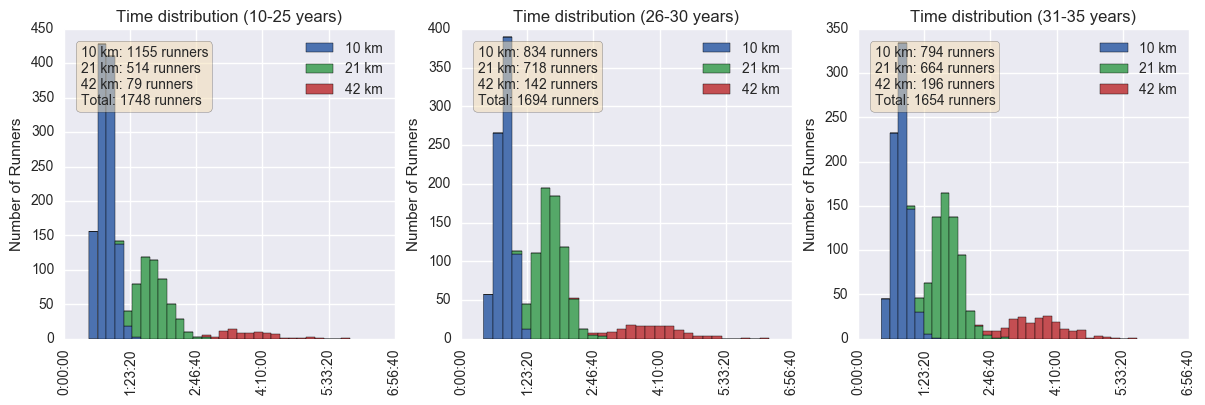

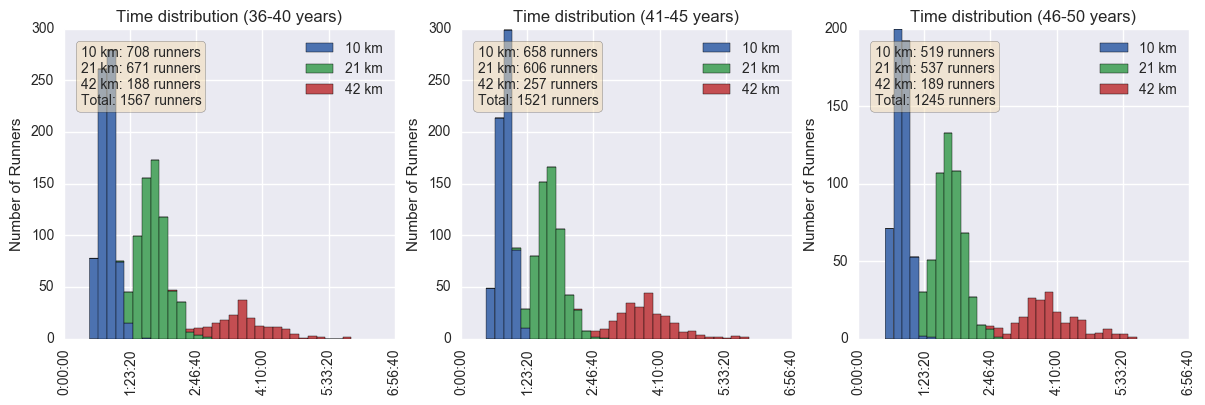

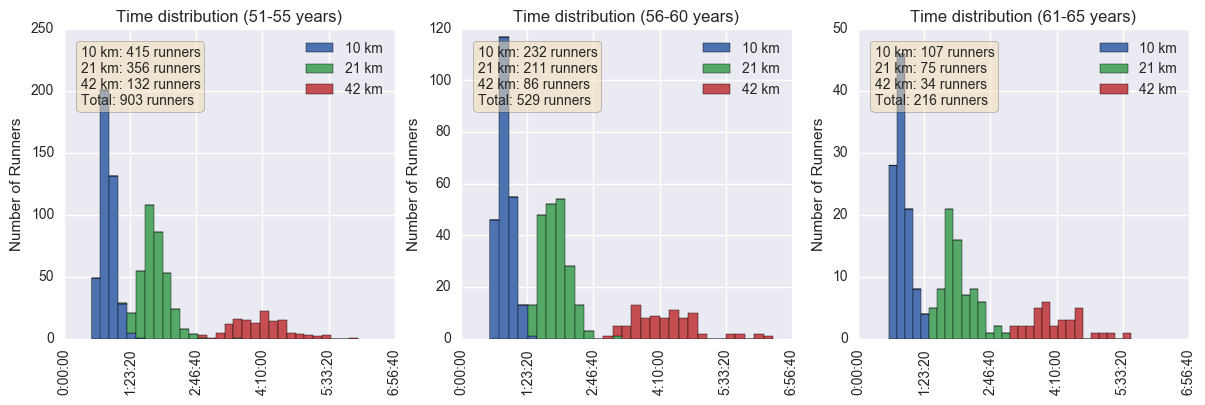

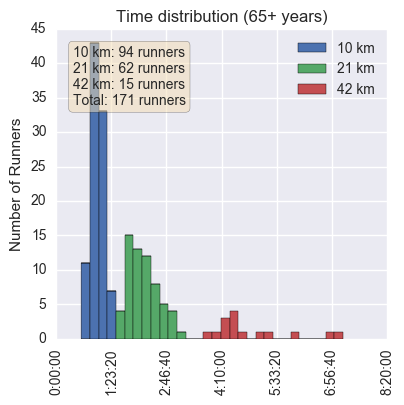

In [24]:
lausanne_2016_utils.plot_time_distribution_by_age(lausanne_marathon_2016_cleaned, 'age category')

#### Performance for 10 km running

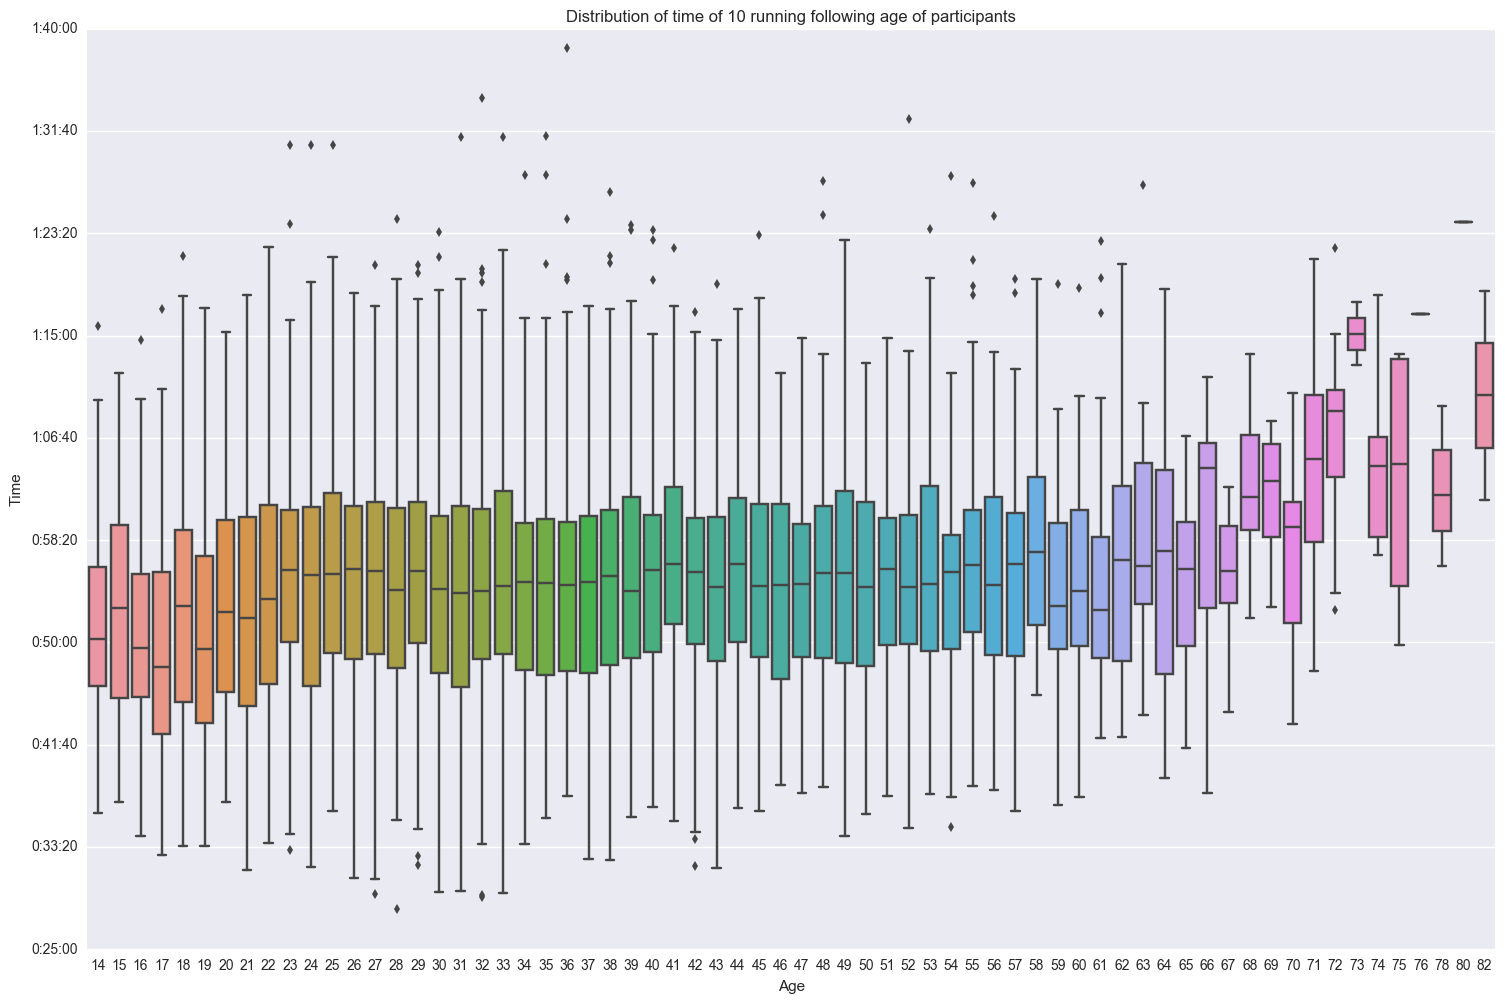

In [25]:
lausanne_2016_utils.plot_performance_according_to_running_type(lausanne_marathon_2016_10km, 10, 'age', size=10, aspect=1.5)

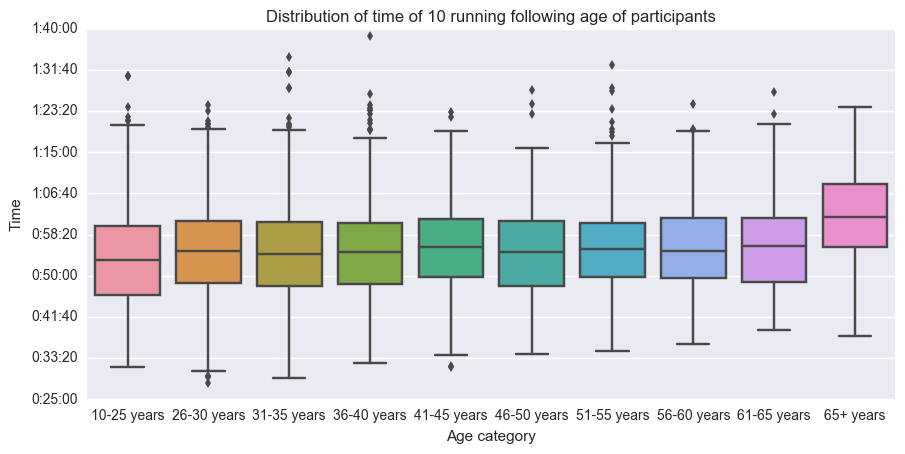

In [26]:
lausanne_2016_utils.plot_performance_according_to_running_type(lausanne_marathon_2016_10km, 10, 'age category')

#### Performance for demi-marathon

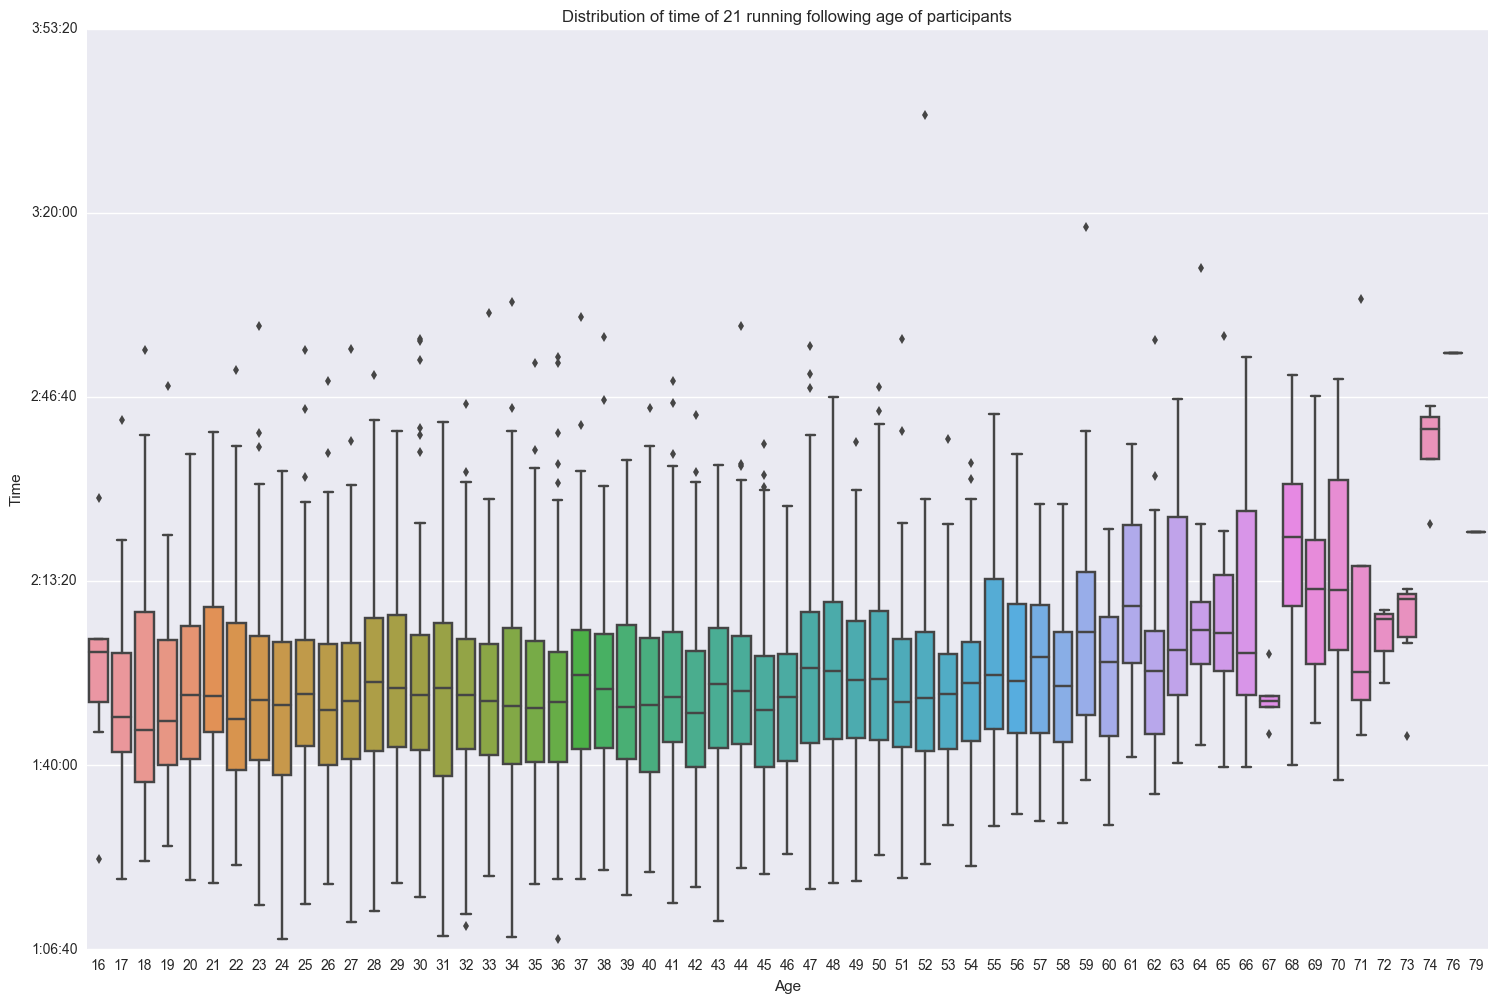

In [27]:
lausanne_2016_utils.plot_performance_according_to_running_type(lausanne_marathon_2016_21km, 21, 'age', size=10, aspect=1.5)

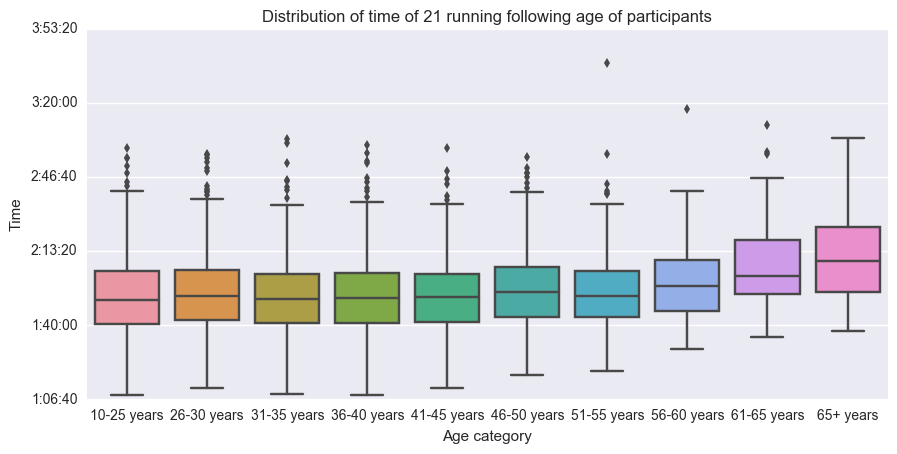

In [28]:
lausanne_2016_utils.plot_performance_according_to_running_type(lausanne_marathon_2016_21km, 21, 'age category')

#### Performance for marathon

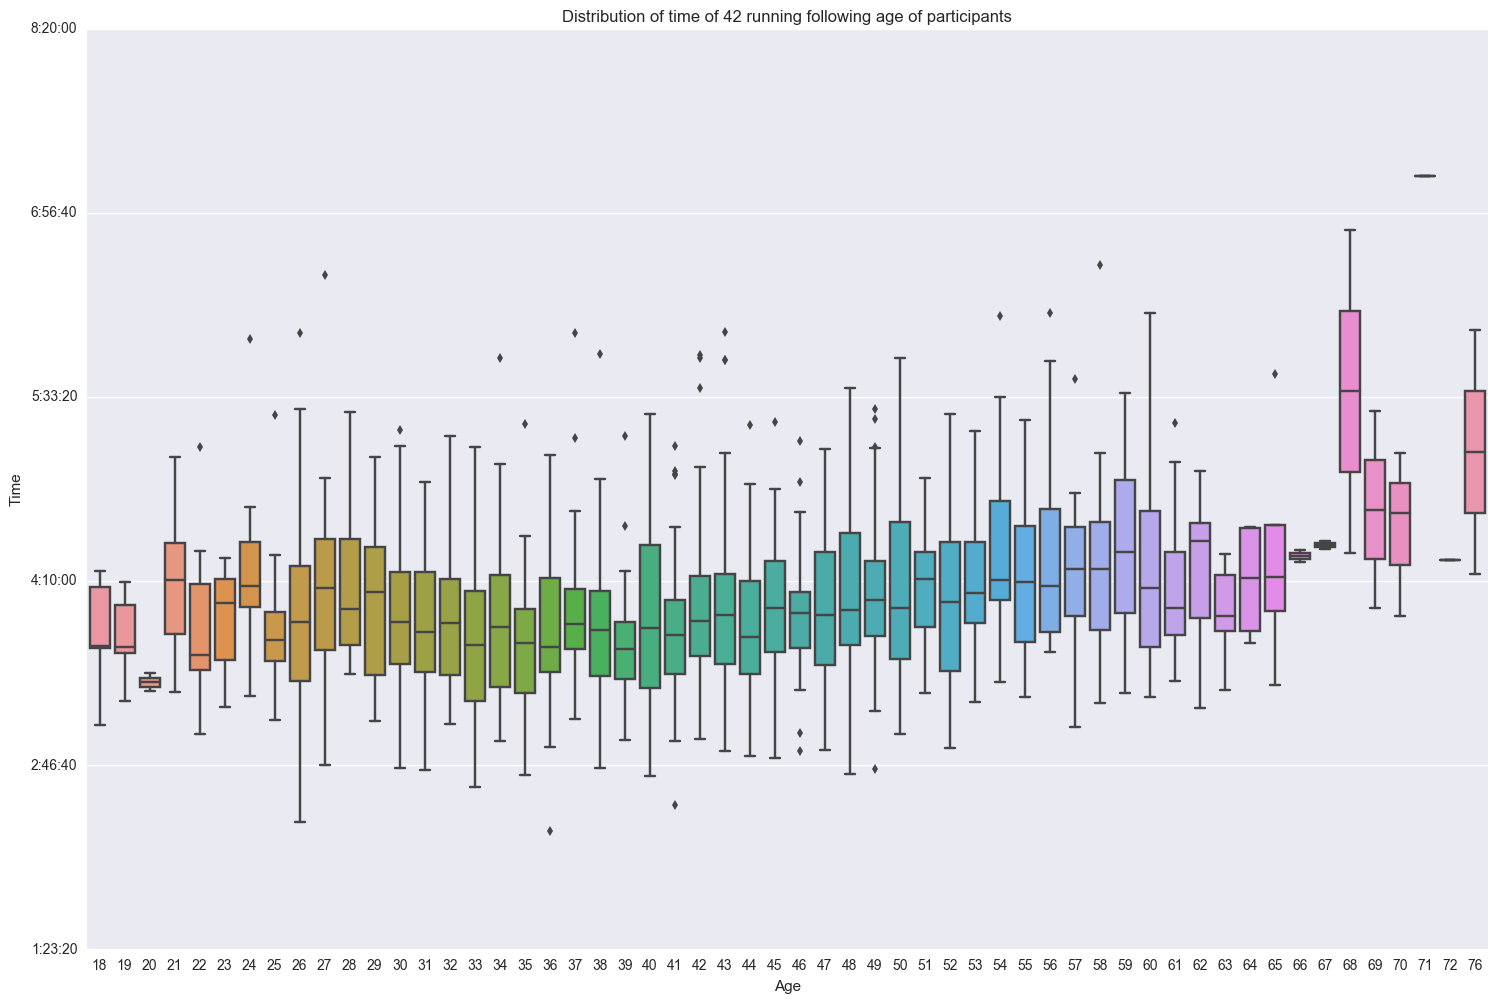

In [29]:
lausanne_2016_utils.plot_performance_according_to_running_type(lausanne_marathon_2016_42km, 42, 'age', size=10, aspect=1.5)

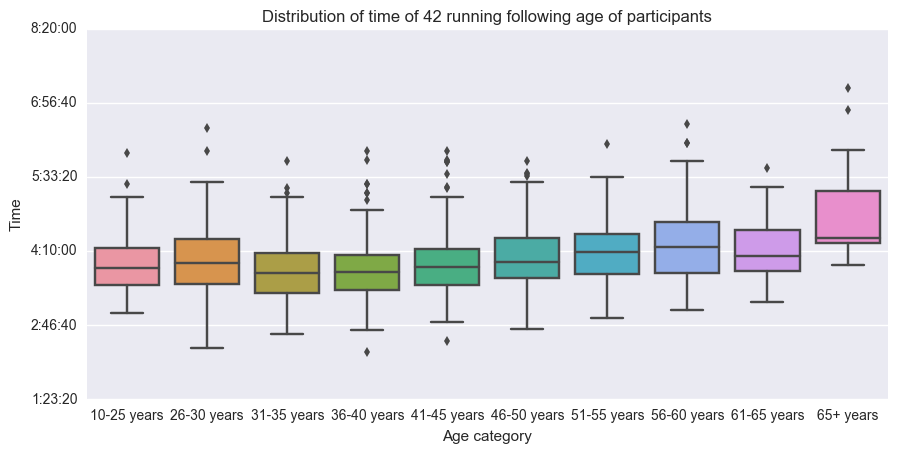

In [30]:
lausanne_2016_utils.plot_performance_according_to_running_type(lausanne_marathon_2016_42km, 42, 'age category')

#### Analysis of results

Globally, we observe more real differences at the extremes. But are these differences significant? We decide to compute ANOVA and Tukey HSD to verify it.

In [31]:
results_10km = study_utils.compute_anova_and_tukey_hsd(lausanne_marathon_2016_10km, 'age category', 'time')
print('F value: ' + str(results_10km['f_value']) + '\nP value: ' + str(results_10km['p_value']) + '\n')
results_10km['tukey_hsd'].rename(columns=lambda x: x.strip(), inplace=True)
results_10km['tukey_hsd'].set_index(['group1', 'group2'])

F value: 10.600679425
P value: 1.89236224134e-16



meandiff     lower     upper  reject
group1      group2                                           
10-25 years 26-30 years   74.8631   -7.0104  156.7366  False 
            31-35 years   72.9489  -10.1136  156.0113  False 
            36-40 years   94.8630    8.8629  180.8630  True  
            41-45 years  130.3506   42.3481  218.3531  True  
            46-50 years   83.3183  -11.8961  178.5328  False 
            51-55 years  132.4343   29.3163  235.5524  True  
            56-60 years  155.4094   25.7801  285.0387  True  
            61-65 years  179.7450   -2.3285  361.8185  False 
            65+ years    521.5436  328.2906  714.7966  True  
26-30 years 31-35 years   -1.9143  -91.2518   87.4232  False 
            36-40 years   19.9999  -72.0753  112.0750  False 
            41-45 years   55.4875  -38.4607  149.4356  False 
            46-50 years    8.4552  -92.2802  109.1906  False 
            51-55 years   57.5712  -50.6654  165.8078  False 
            56-60 years   80.5463  -53.1907  214.2833  False 
            61-65 years  104.8819  -80.1386  289.9024  False 
            65+ years    446.6805  250.6485  642.7125  True  
31-35 years 36-40 years   21.9141  -71.2198  115.0481  False 
            41-45 years   57.4017  -37.5844  152.3878  False 
            46-50 years   10.3695  -91.3346  112.0735  False 
            51-55 years   59.4855  -49.6532  168.6242  False 
            56-60 years   82.4606  -52.0076  216.9287  False 
            61-65 years  106.7962  -78.7535  292.3458  False 
            65+ years    448.5947  252.0632  645.1262  True  
36-40 years 41-45 years   35.4876  -62.0778  133.0530  False 
            46-50 years  -11.5447 -115.6617   92.5724  False 
            51-55 years   37.5714  -73.8194  148.9621  False 
            56-60 years   60.5464  -75.7559  196.8487  False 
            61-65 years   84.8820 -102.0011  271.7652  False 
            65+ years    426.6806  228.8896  624.4716  True  
41-45 years 46-50 years  -47.0323 -152.8093   58.7448  False 
            51-55 years    2.0838 -110.8601  115.0277  False 
            56-60 years   25.0588 -112.5157  162.6333  False 
            61-65 years   49.3944 -138.4186  237.2075  False 
            65+ years    391.1930  192.5232  589.8629  True  
46-50 years 51-55 years   49.1160  -69.5334  167.7654  False 
            56-60 years   72.0911  -70.2047  214.3869  False 
            61-65 years   96.4267  -94.8718  287.7252  False 
            65+ years    438.2253  236.2573  640.1933  True  
51-55 years 56-60 years   22.9751 -124.7261  170.6763  False 
            61-65 years   47.3107 -148.0419  242.6633  False 
            65+ years    389.1093  183.2972  594.9213  True  
56-60 years 61-65 years   24.3356 -186.2186  234.8898  False 
            65+ years    366.1342  145.8411  586.4272  True  
61-65 years 65+ years    341.7986   87.0908  596.5063  True

In [32]:
results_21km = study_utils.compute_anova_and_tukey_hsd(lausanne_marathon_2016_21km, 'age category', 'time')
print('F value: ' + str(results_21km['f_value']) + '\nP value: ' + str(results_21km['p_value']) + '\n')
results_21km['tukey_hsd'].rename(columns=lambda x: x.strip(), inplace=True)
results_21km['tukey_hsd'].set_index(['group1', 'group2'])

F value: 13.7666013841
P value: 4.54754197776e-22



meandiff     lower      upper  reject
group1      group2                                             
10-25 years 26-30 years    45.3092 -145.8940   236.5123  False 
            31-35 years   -34.5488 -228.9686   159.8710  False 
            36-40 years     6.9110 -187.0659   200.8878  False 
            41-45 years   -18.9163 -217.3542   179.5216  False 
            46-50 years   134.0981  -70.1068   338.3030  False 
            51-55 years    84.8437 -143.3410   313.0284  False 
            56-60 years   350.9225   80.3524   621.4925  True  
            61-65 years   766.1908  357.1384  1175.2432  True  
            65+ years    1073.7645  628.8595  1518.6696  True  
26-30 years 31-35 years   -79.8580 -258.0307    98.3148  False 
            36-40 years   -38.3982 -216.0875   139.2910  False 
            41-45 years   -64.2255 -246.7743   118.3233  False 
            46-50 years    88.7889 -100.0128   277.5906  False 
            51-55 years    39.5345 -174.9759   254.0450  False 
            56-60 years   305.6133   46.4712   564.7553  True  
            61-65 years   720.8816  319.2968  1122.4663  True  
            65+ years    1028.4553  590.4063  1466.5044  True  
31-35 years 36-40 years    41.4597 -139.6863   222.6058  False 
            41-45 years    15.6325 -170.2828   201.5477  False 
            46-50 years   168.6469  -23.4117   360.7055  False 
            51-55 years   119.3925  -97.9900   336.7750  False 
            56-60 years   385.4712  123.9468   646.9956  True  
            61-65 years   800.7395  397.6133  1203.8657  True  
            65+ years    1108.3133  668.8507  1547.7759  True  
36-40 years 41-45 years   -25.8273 -211.2792   159.6247  False 
            46-50 years   127.1871  -64.4230   318.7973  False 
            51-55 years    77.9328 -139.0536   294.9191  False 
            56-60 years   344.0115   82.8162   605.2067  True  
            61-65 years   759.2798  356.3671  1162.1925  True  
            65+ years    1066.8536  627.5868  1506.1203  True  
41-45 years 46-50 years   153.0144  -43.1107   349.1395  False 
            51-55 years   103.7600 -117.2234   324.7434  False 
            56-60 years   369.8388  105.3136   634.3639  True  
            61-65 years   785.1071  380.0277  1190.1864  True  
            65+ years    1092.6808  651.4259  1533.9357  True  
46-50 years 51-55 years   -49.2544 -275.4307   176.9219  False 
            56-60 years   216.8244  -52.0540   485.7027  False 
            61-65 years   632.0927  224.1572  1040.0281  True  
            65+ years     939.6664  495.7881  1383.5447  True  
51-55 years 56-60 years   266.0787  -21.4351   553.5926  False 
            61-65 years   681.3470  260.8950  1101.7991  True  
            65+ years     988.9208  533.5127  1444.3289  True  
56-60 years 61-65 years   415.2683  -29.6135   860.1501  False 
            65+ years     722.8421  244.7872  1200.8969  True  
61-65 years 65+ years     307.5738 -260.4510   875.5986  False

In [33]:
results_42km = study_utils.compute_anova_and_tukey_hsd(lausanne_marathon_2016_42km, 'age category', 'time')
print('F value: ' + str(results_42km['f_value']) + '\nP value: ' + str(results_42km['p_value']) + '\n')
results_42km['tukey_hsd'].rename(columns=lambda x: x.strip(), inplace=True)
results_42km['tukey_hsd'].set_index(['group1', 'group2'])

F value: 12.3027422023
P value: 7.33119813448e-19



meandiff      lower      upper  reject
group1      group2                                              
10-25 years 26-30 years   294.7210  -680.2706  1269.7126  False 
            31-35 years  -477.2610 -1402.9971   448.4752  False 
            36-40 years  -363.1966 -1294.5739   568.1806  False 
            41-45 years   -63.1400  -956.7582   830.4782  False 
            46-50 years   415.7732  -514.8747  1346.4212  False 
            51-55 years   792.3058  -195.7994  1780.4110  False 
            56-60 years  1372.4966   289.9623  2455.0309  True  
            61-65 years   887.3071  -537.4757  2312.0900  False 
            65+ years    3575.9013  1619.4582  5532.3443  True  
26-30 years 31-35 years  -771.9820 -1537.4880    -6.4759  True  
            36-40 years  -657.9176 -1430.2359   114.4007  False 
            41-45 years  -357.8610 -1084.1980   368.4761  False 
            46-50 years   121.0522  -650.3864   892.4909  False 
            51-55 years   497.5848  -342.2746  1337.4443  False 
            56-60 years  1077.7756   128.6220  2026.9292  True  
            61-65 years   592.5862  -733.6937  1918.8660  False 
            65+ years    3281.1803  1395.2637  5167.0969  True  
31-35 years 36-40 years   114.0644  -595.0579   823.1866  False 
            41-45 years   414.1210  -244.6235  1072.8654  False 
            46-50 years   893.0342   184.8701  1601.1983  True  
            51-55 years  1269.5668   487.4270  2051.7066  True  
            56-60 years  1849.7576   951.2748  2748.2404  True  
            61-65 years  1364.5681    74.0655  2655.0707  True  
            65+ years    4053.1622  2192.2323  5914.0922  True  
36-40 years 41-45 years   300.0566  -366.5920   966.7052  False 
            46-50 years   778.9698    63.4473  1494.4924  True  
            51-55 years  1155.5024   366.6939  1944.3109  True  
            56-60 years  1735.6932   831.3993  2639.9871  True  
            61-65 years  1250.5038   -44.0514  2545.0589  False 
            65+ years    3939.0979  2075.3553  5802.8405  True  
41-45 years 46-50 years   478.9132  -186.7161  1144.5425  False 
            51-55 years   855.4458   111.5986  1599.2930  True  
            56-60 years  1435.6366   570.2827  2300.9905  True  
            61-65 years   950.4471  -317.2133  2218.1076  False 
            65+ years    3639.0412  1793.8783  5484.2042  True  
46-50 years 51-55 years   376.5326  -411.4146  1164.4798  False 
            56-60 years   956.7234    53.1807  1860.2661  True  
            61-65 years   471.5339  -822.4966  1765.5645  False 
            65+ years    3160.1280  1296.7498  5023.5063  True  
51-55 years 56-60 years   580.1908  -382.4284  1542.8100  False 
            61-65 years    95.0013 -1240.9483  1430.9510  False 
            65+ years    2783.5955   890.8660  4676.3249  True  
56-60 years 61-65 years  -485.1895 -1892.4173   922.0383  False 
            65+ years    2203.4047   259.7088  4147.1005  True  
61-65 years 65+ years    2688.5941   535.4385  4841.7497  True

In all the cases, p value is extremly low. This means that we can reject null hypothesis H0 and conclude safely that there are significant differences between age categories!

## Effective performance according to BIB number

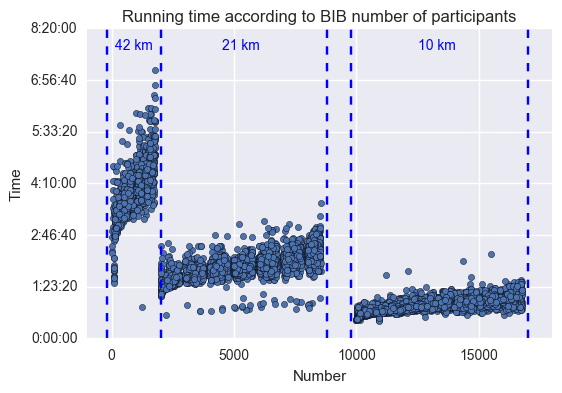

In [34]:
lausanne_2016_utils.plot_time_distribution_by_bib_numbers(lausanne_marathon_2016_cleaned)

We can recognize three major patterns following the BIB number of participants. Indeed, for each subdivisions, the higher the BIB number is, the lower the performance time is, globally.

Notice that BIB numbers are given by the organizators of Lausanne Marathon, and as we can read on <a href="http://fr.lausanne-marathon.com/inscription/inscriptions/inscription-online/">the official website</a>, each participant is asked to indicate his "estimated time of running for the attribution of start blocks", in oder to categorize the runners accordingly.

## Study by sex

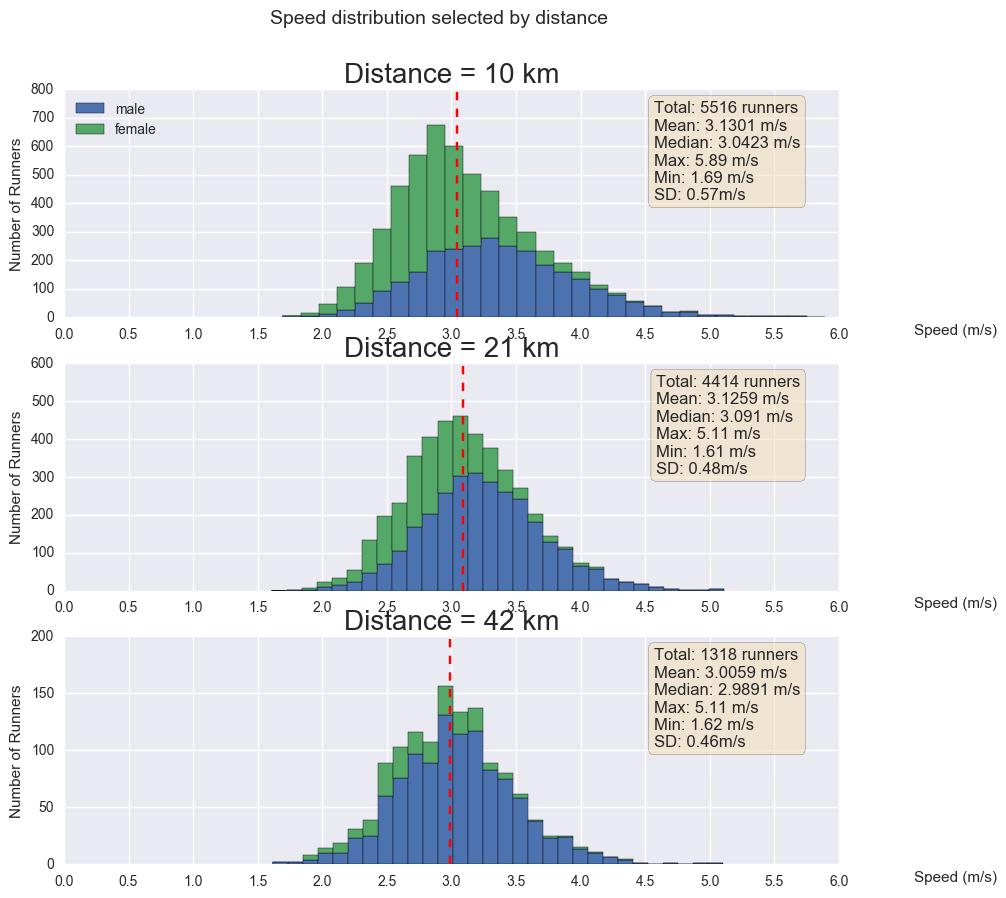

In [35]:
# Creation of figure
fig = plt.figure()
fig.tight_layout
fig.set_size_inches(10, 10)
fig.suptitle('Speed distribution selected by distance', fontsize=14)
lausanne_2016_utils.plot_speed_distribution_by_running(fig, lausanne_marathon_2016_10km, '10 km', 1, np.arange(0,900, 100))
lausanne_2016_utils.plot_speed_distribution_by_running(fig, lausanne_marathon_2016_21km, '21 km', 2, np.arange(0,700, 100))
lausanne_2016_utils.plot_speed_distribution_by_running(fig, lausanne_marathon_2016_42km, '42 km', 3, np.arange(0,250, 50))

As we can expect the fastest runners have made the 10 km, as the distance is shorter, the speed by kilometer can be greater.

But unexpectedly the average speed seems very close between runners despite the difference of the distance, in order to understand this phenomenon we need to go further in the study and study the past of runners.

### Statistical analysis

** Overview **

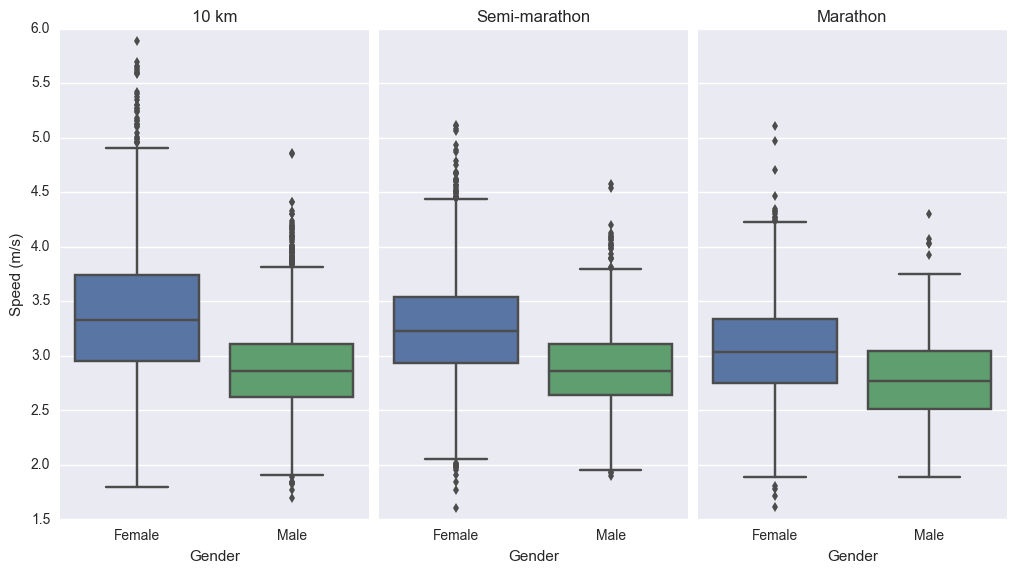

In [36]:
plot = sns.factorplot(data=lausanne_marathon_2016_cleaned, x='sex', y='speed (m/s)', col = 'distance (km)', size=5, kind='box')
plot.set_xlabels('Gender')
plot.set_ylabels('Speed (m/s)')
titles = ['10 km', 'Semi-marathon', 'Marathon']
for ax, title in zip(plot.axes.flat, titles):
    ax.set_title(title)
    ax.set(xticklabels=['Female', 'Male'])
plot.fig.set_size_inches(10, 6)

Following the boxplots, differences seem to be significant.

** 10 km running **

In [37]:
results_10km = study_utils.compute_anova_and_tukey_hsd(lausanne_marathon_2016_10km, 'sex', 'speed (m/s)')
print('F value: ' + str(results_10km['f_value']) + '\nP value: ' + str(results_10km['p_value']) + '\n')
results_10km['tukey_hsd'].rename(columns=lambda x: x.strip(), inplace=True)
results_10km['tukey_hsd'].set_index(['group1', 'group2'])

F value: 1259.85300243
P value: 1.01333050347e-248



,,meandiff,lower,upper,reject
group1,group2,,,,
female,male,0.4899,0.4628,0.517,True


** Semi-marathon **

In [38]:
results_21km = study_utils.compute_anova_and_tukey_hsd(lausanne_marathon_2016_21km, 'sex', 'speed (m/s)')
print('F value: ' + str(results_21km['f_value']) + '\nP value: ' + str(results_21km['p_value']) + '\n')
results_21km['tukey_hsd'].rename(columns=lambda x: x.strip(), inplace=True)
results_21km['tukey_hsd'].set_index(['group1', 'group2'])

F value: 671.355174951
P value: 6.55496134736e-138



,,meandiff,lower,upper,reject
group1,group2,,,,
female,male,0.3663,0.3385,0.394,True


** Marathon **

In [39]:
results_42km = study_utils.compute_anova_and_tukey_hsd(lausanne_marathon_2016_42km, 'sex', 'speed (m/s)')
print('F value: ' + str(results_42km['f_value']) + '\nP value: ' + str(results_42km['p_value']) + '\n')
results_42km['tukey_hsd'].rename(columns=lambda x: x.strip(), inplace=True)
results_42km['tukey_hsd'].set_index(['group1', 'group2'])

F value: 61.5033216457
P value: 9.07714985087e-15



,,meandiff,lower,upper,reject
group1,group2,,,,
female,male,0.2616,0.1961,0.327,True


As we can see, no matter the running we consider, the difference between male and female is significant as we can reject H0 hypothesis. Notice that p-value is higher for the case of marathon, as the distribution seem to be more similar (see previous plots).

## Focus on teams and single runners

First, let's display the distribution of runners with and without teams.

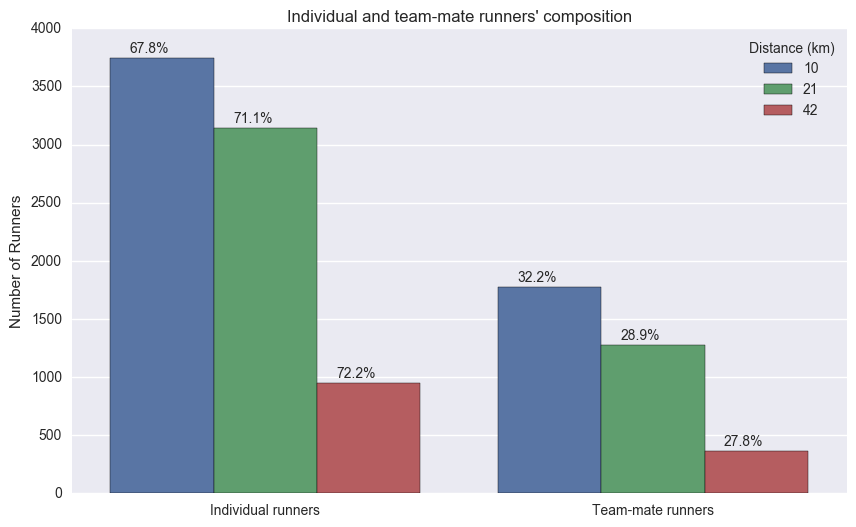

In [40]:
total_10 = len(lausanne_marathon_2016_10km)
total_21 = len(lausanne_marathon_2016_21km)
total_42 = len(lausanne_marathon_2016_42km)
lausanne_2016_utils.plot_distribution_team_individuals(lausanne_marathon_2016_cleaned, total_10, total_21, total_42)

The repartition individual/team seems quite equivalent between the different races offered by the event.
The teams are more present in the 10 km. The distance seems more appropriate for the teams, it's short enough to be a good challenge between beginner friends.

### Statistical analysis

Let's see if being in team has a real impact on the performance.

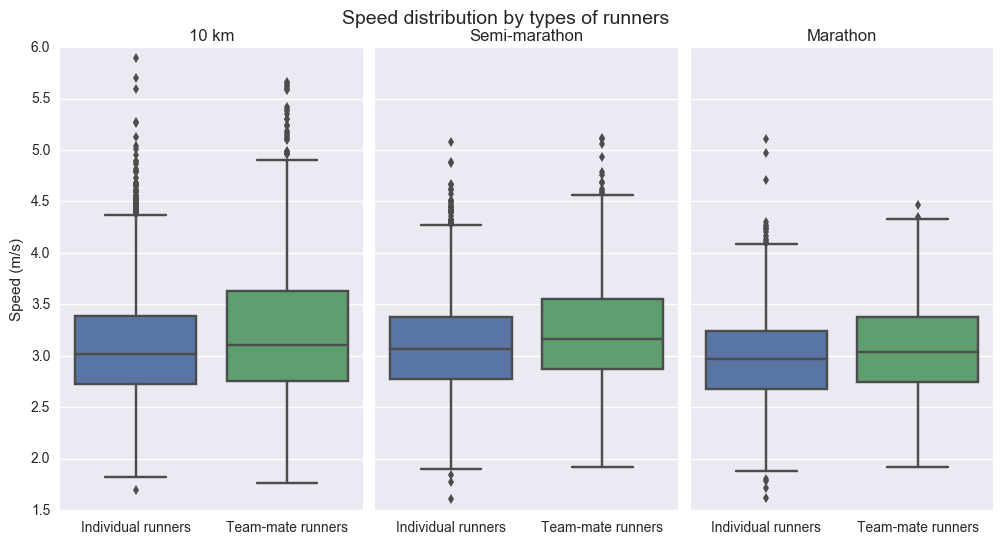

In [41]:
plot = sns.factorplot(data=lausanne_marathon_2016_cleaned, x='profile', y='speed (m/s)', col = 'distance (km)', kind='box')
plot.fig.suptitle('Speed distribution by types of runners', fontsize=14)
titles = ['10 km', 'Semi-marathon', 'Marathon']
for ax, title in zip(plot.axes.flat, titles):
    ax.set_title(title)
    ax.set(xticklabels=['Individual runners', 'Team-mate runners'])
plot.set_xlabels('')
plot.set_ylabels('Speed (m/s)')
plot.fig.set_size_inches(10,6)

In [42]:
lausanne_2016_utils.display_information_speed(lausanne_marathon_2016_cleaned)

10-km running
Median for individual runners: 3.02206104563 m/s
Median for runners in team: 3.10559006211 m/s
*************************************************
21-km running
Median for individual runners: 3.06636491377 m/s
Median for runners in team: 3.16837665631 m/s
*************************************************
42-km running
Median for individual runners: 2.96547341665 m/s
Median for runners in team: 3.03907380608 m/s
*************************************************


Actually the teams are better on average compared to individual runners, but the best performance comes from individual runners.
From the graph above, we can notice that for "average" people, to be part of a team seems to be a motivational factor, compared to excellent runners who prefer doing the race alone.

Running ANOVA permits us to draw the same conclusion, as showed in the following results. Notice that for the marathon, p value is higher than for the other races as medians tend to be similar between the two categories (runners with and without team), even if it is not sufficiently high to maintain H0 hypothesis (i.e. similar distributions).

In [43]:
results_teams_10km = study_utils.compute_anova_and_tukey_hsd(lausanne_marathon_2016_10km, 'profile', 'speed (m/s)')
print('F value: ' + str(results_teams_10km['f_value']) + '\nP value: ' + str(results_teams_10km['p_value']) + '\n')
results_teams_10km['tukey_hsd'].rename(columns=lambda x: x.strip(), inplace=True)
results_teams_10km['tukey_hsd'].set_index(['group1', 'group2'])

F value: 70.0639961898
P value: 7.20395185166e-17



,,meandiff,lower,upper,reject
group1,group2,,,,
Individual,Team-mate,0.1362,0.1043,0.1681,True


In [44]:
results_teams_21km = study_utils.compute_anova_and_tukey_hsd(lausanne_marathon_2016_21km, 'profile', 'speed (m/s)')
print('F value: ' + str(results_teams_21km['f_value']) + '\nP value: ' + str(results_teams_21km['p_value']) + '\n')
results_teams_21km['tukey_hsd'].rename(columns=lambda x: x.strip(), inplace=True)
results_teams_21km['tukey_hsd'].set_index(['group1', 'group2'])

F value: 79.599228337
P value: 6.59735898554e-19



,,meandiff,lower,upper,reject
group1,group2,,,,
Individual,Team-mate,0.1397,0.109,0.1704,True


In [45]:
results_teams_42km = study_utils.compute_anova_and_tukey_hsd(lausanne_marathon_2016_42km, 'profile', 'speed (m/s)')
print('F value: ' + str(results_teams_42km['f_value']) + '\nP value: ' + str(results_teams_42km['p_value']) + '\n')
results_teams_42km['tukey_hsd'].rename(columns=lambda x: x.strip(), inplace=True)
results_teams_42km['tukey_hsd'].set_index(['group1', 'group2'])

F value: 9.66344916911
P value: 0.00192000057478



,,meandiff,lower,upper,reject
group1,group2,,,,
Individual,Team-mate,0.0879,0.0324,0.1434,True


In [46]:
team_selected = lausanne_marathon_2016_cleaned[lausanne_marathon_2016_cleaned['profile'] == 'Team-mate']
lausanne_marathon_2016_cleaned['time difference team'] = lausanne_marathon_2016_cleaned.apply(study_utils.compute_time_to_best_in_team,args=(team_selected,), axis=1)

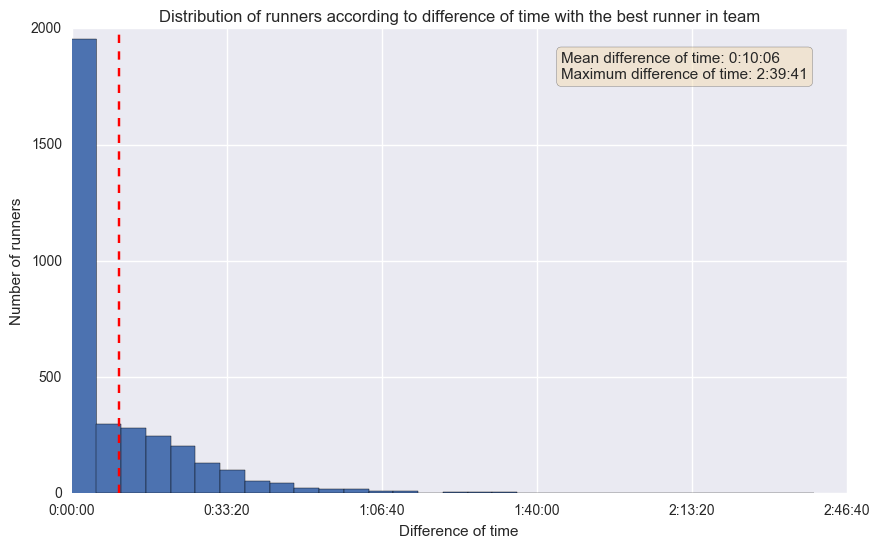

In [47]:
lausanne_marathon_team = lausanne_marathon_2016_cleaned[lausanne_marathon_2016_cleaned['profile'] == 'Team-mate'].copy()
lausanne_2016_utils.plot_time_difference_distribution(lausanne_marathon_team)

We observe that when runners are in team, they globally share similar performance (time's difference is between 0 and 5 minutes for the majority of runners). This indicates that similar people compose each team and they ran together, as we can expect it.

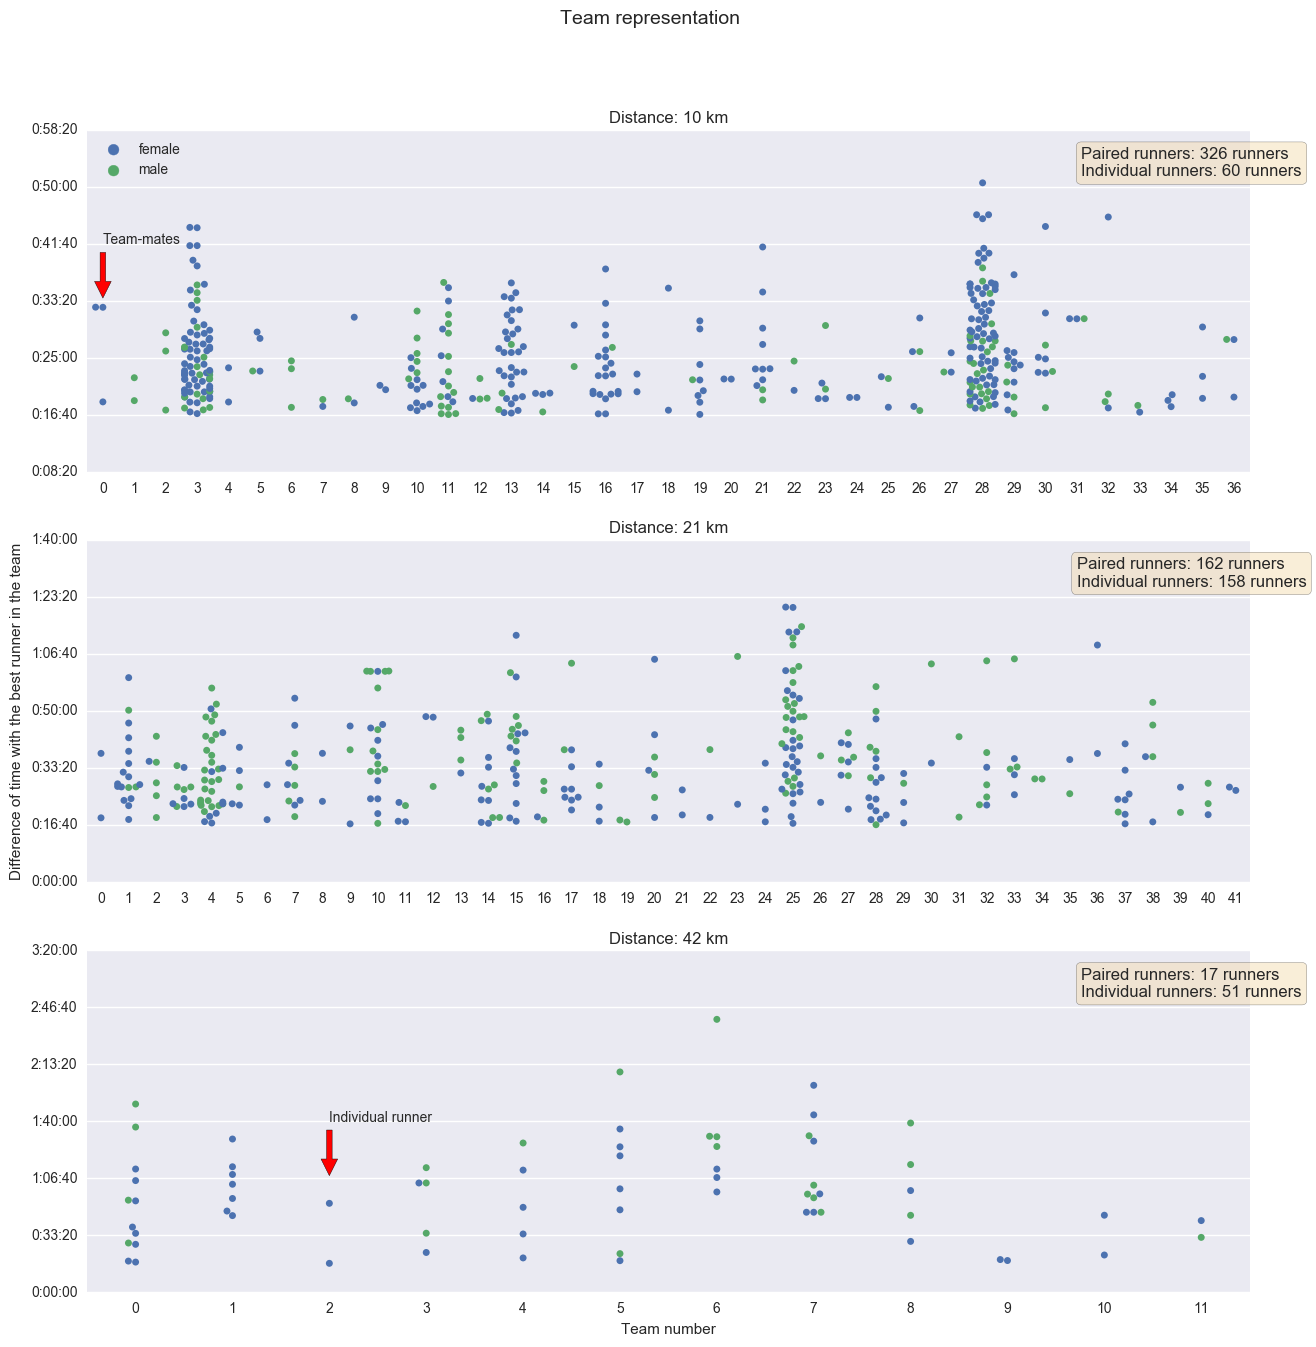

In [48]:
fig = plt.figure()
fig.tight_layout
fig.set_size_inches(15, 15)
fig.suptitle('Team representation', fontsize=14)
annotation_plot1 = [311,'Team-mates',(0,2000), (0,2500)]
annotation_plot2 = [313,'Individual runner',(2,4000), (2,6000)]
lausanne_2016_utils.plot_scatter_difference_time_number(fig, lausanne_marathon_2016_cleaned, 10, 311, annotation_plot1)
lausanne_2016_utils.plot_scatter_difference_time_number(fig, lausanne_marathon_2016_cleaned, 21, 312)
lausanne_2016_utils.plot_scatter_difference_time_number(fig, lausanne_marathon_2016_cleaned, 42, 313, annotation_plot2)

As we can noticed from the previous study most of pair/group of runner have finished the race together. In order to go futher we need to study the situation of those who finihsed later. (study above take runners wither a minimum late of 1000 seconds after the best runners in the team).

We have considered a pair/group runner if the distance time if weaker than 30sec. It is very  unlikely that any two runners would have the exact same start and end time (within 30 sec) unless they ran together, so these visual clusters should be very accurate in showing running pairs/groups.Based on the graph there are distinct differences in "belong to a team" in the difference race, Based on the graph the 10km seems to be the more solidary one, where most people in a team ran in pair/group (326 runners compared to 60 runners who have finished alone). The 21km had a half of runner who have ran in pair/group whereas the 42km seems the more individiual one where 51 runners finished alone compared to 17 runners in teams/groups. 42 km is a long distance, the challenge is often individual and often seen as personnal reward of long hour of training, this could explain the difference in type of runners belong to a team.